In [137]:
from dataclasses import dataclass
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import PULP_CBC_CMD, LpMinimize, LpProblem, LpStatus, LpVariable, lpSum, value

### Define the battery properties

In [138]:
@dataclass
class Battery:
    capacity: float
    charge_rate: float
    soc_range_percentage: tuple[float, float]

    @property
    def soc_min(self) -> float:
        return self.capacity * self.soc_range_percentage[0] / 100

    @property
    def soc_max(self) -> float:
        return self.capacity * self.soc_range_percentage[1] / 100

    @property
    def power(self) -> float:
        return self.capacity * self.charge_rate


battery = Battery(capacity=250, charge_rate=0.5, soc_range_percentage=(10, 90))

print(
    f"{battery.capacity = } ({battery.soc_min = }, {battery.soc_max = })"
    f"\n{battery.charge_rate = }"
    f"\n{battery.power = }"
)

battery.capacity = 250 (battery.soc_min = 25.0, battery.soc_max = 225.0)
battery.charge_rate = 0.5
battery.power = 125.0


### Load energy prices for 2024

In [139]:
BASE_DIR = Path().resolve()

prices = pd.read_csv(BASE_DIR / "data" / "prices_with_generation.csv")

prices["timestamp"] = pd.to_datetime(prices["timestamp"])
prices["hour"] = prices["timestamp"].dt.hour
prices["date"] = prices["timestamp"].dt.date
prices["dayofweek"] = prices["timestamp"].dt.dayofweek
prices = prices.set_index("timestamp").sort_index(ascending=True)

timestamps = prices.index  # will be used a lot when setting up constraints

# €/Wh -> €/kWh: Charge rate and SOC (state of charge) in the solution will be in kWh
prices["energy_price"] = prices["energy_price"] / 1000

prices.head()

,energy_price,time_block,generation,hour,date,dayofweek
timestamp,,,,,,
2024-01-01 01:00:00,0.00010,4.0,0.0,1,2024-01-01,0
2024-01-01 02:00:00,0.00001,4.0,0.0,2,2024-01-01,0
2024-01-01 03:00:00,0.00003,4.0,0.0,3,2024-01-01,0
2024-01-01 04:00:00,0.00000,4.0,0.0,4,2024-01-01,0
2024-01-01 05:00:00,0.00000,4.0,0.0,5,2024-01-01,0


#### Utility functions for solving the constructed linear programming problem and examining the solution on a chart

In [140]:
def solve_lp(
    objective: LpProblem,
    charge_rate_var: dict[Any, LpVariable],
    soc_var: dict[Any, LpVariable],
    prices: pd.DataFrame,
) -> pd.DataFrame:
    # --------------------
    # Solve
    # --------------------
    objective.writeLP("ilp-model.lp")
    objective.solve(PULP_CBC_CMD(msg=False, timeLimit=120))

    saved = -value(objective.objective)

    print("Solver Status:", LpStatus[objective.status])
    print(f"Total savings: {saved:.2f}€")

    # --------------------
    # Results
    # --------------------
    res = pd.DataFrame(
        {
            "timestamp": prices.index,
            "price": prices["energy_price"],
            "battery(x)": [charge_rate_var[t].varValue for t in prices.index],
            "soc": [soc_var[t].varValue for t in prices.index],
        }
    )
    res["charging"] = res["battery(x)"].clip(lower=0)
    res["discharging"] = -res["battery(x)"].clip(upper=0)
    res["cost"] = res["price"] * res["battery(x)"]

    return res


def plot_lp_solution(result: pd.DataFrame, month: int = 8) -> None:
    # Filter for August
    august = result[result["timestamp"].dt.month == month]

    # Pick a random start date (within available range)
    start_date = np.random.choice(august["timestamp"].dt.date.unique())
    start_date = pd.Timestamp(start_date)
    end_date = start_date + pd.Timedelta(days=7)

    # Slice the week
    week = result[
        (result["timestamp"] >= start_date) & (result["timestamp"] < end_date)
    ]
    week = week.set_index("timestamp")

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(week.index, week["price"], color="blue", label="Price")
    ax1.set_ylabel("Price", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_xlabel("Time")

    ax2 = ax1.twinx()
    ax2.plot(week.index, week["battery(x)"], color="red", label="soc")
    ax2.set_ylabel("Charge rate [kW]", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

    plt.title(f"Price and charge rate: random week starting {start_date.date()}")
    plt.tight_layout()
    plt.show()

    ### RANDOM DAY - repeated code
    start_date = np.random.choice(august["timestamp"].dt.date.unique())
    start_date = pd.Timestamp(start_date)
    end_date = start_date + pd.Timedelta(days=2)

    # Slice the week
    week = result[
        (result["timestamp"] >= start_date) & (result["timestamp"] < end_date)
    ]
    week = week.set_index("timestamp")

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(week.index, week["price"], color="blue", label="Price")
    ax1.set_ylabel("Price", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_xlabel("Time")

    ax2 = ax1.twinx()
    ax2.plot(week.index, week["battery(x)"], color="red", label="soc")
    ax2.set_ylabel("Charge rate [kW]", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # A = result['price'].mean()
    # print(A)
    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

    plt.title(f"Price and charge rate: random 2 days starting {start_date.date()}")
    plt.tight_layout()
    plt.show()


### Problem definition

In [141]:
objective = LpProblem("Peaks", LpMinimize)

### Variable definitions:
- `charge_rate_var[t]`: charging rate of the battery, to be solved for all times `t` 
- `soc_var[t]`: state of charge (SOC) of the battery
- `is_discharging[t]`: Binary flag that specifies if the battery is charging or discharging at time `t` 

In [142]:
charge_rate_var = {
    t: LpVariable(
        f"x_{t}",
        lowBound=-battery.power,
        upBound=battery.power,
        cat="Continuous",
    )
    for t in timestamps
}

soc_var = {
    t: LpVariable(
        f"y_{t}",
        lowBound=battery.soc_min,
        upBound=battery.soc_max,
        cat="Continuous",
    )
    for t in timestamps
}

is_discharging_var = {t: LpVariable(f"b_{t}", cat="Binary") for t in timestamps}

### Objective function
A cost function, linear in all variables, to which we will append constraints on the variables later

In [143]:
objective += (
    lpSum(charge_rate_var[t] * prices.loc[t, "energy_price"] for t in timestamps),
    "minimize_energy_cost",
)

### Constraints
#### Constraint set 0 - Initial condition
- Assume a fully charged battery at the start

In [144]:
objective += soc_var[timestamps[0]] == battery.soc_max, "initial_SOC"

#### Constraint set 1
- SOC between two subsequent timestamps are connected through the charge rate between them
- Charging / discharging limits based on the state of charge: avoid over(dis)charging the battery

Solver Status: Optimal
Total savings: 11858.90€


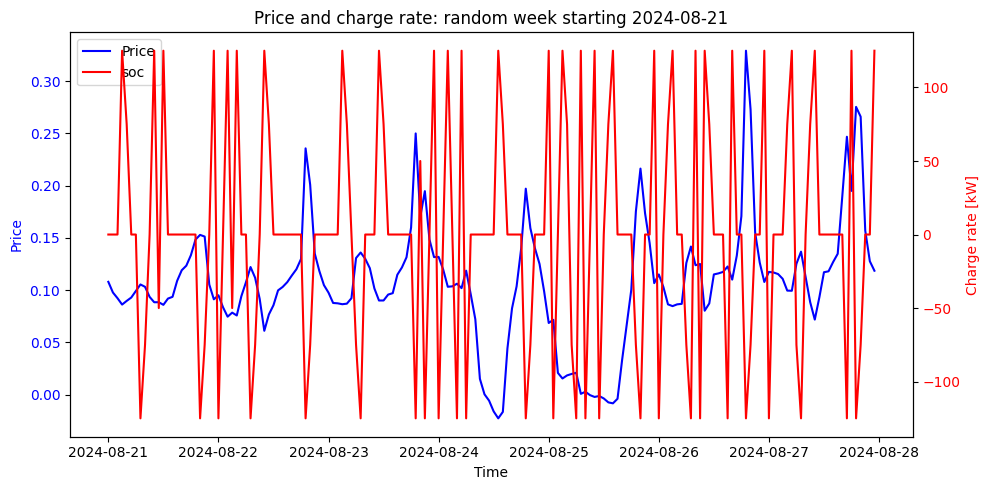

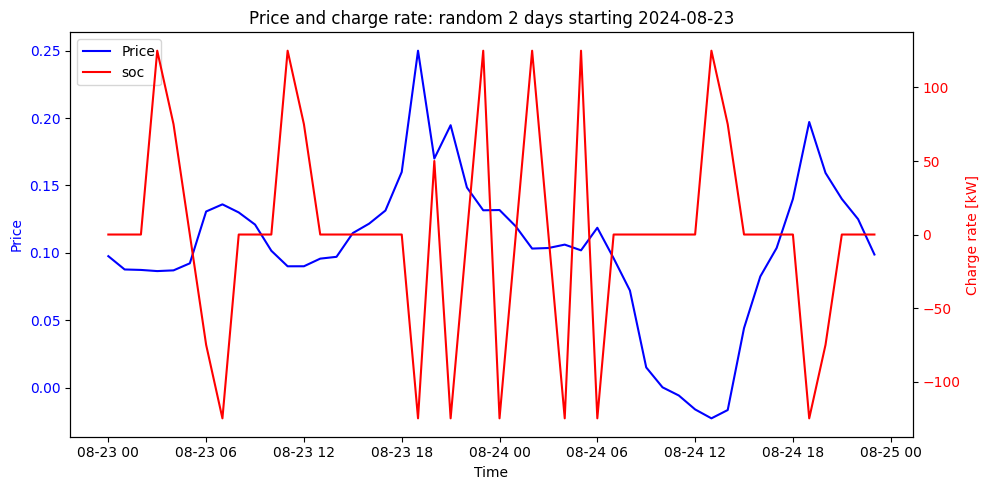

In [145]:
# SOC between two subsequent steps are connected through the charge rate between them
for t, t_prev in zip(timestamps[1:], timestamps[:-1]):
    objective += (
        soc_var[t] == soc_var[t_prev] + charge_rate_var[t_prev],
        f"soc_balance_{t}",
    )

# Charging / discharging limits based on SOC: avoid over(dis)charging the battery
for t in timestamps:
    objective += (
        charge_rate_var[t] >= -(soc_var[t] - battery.soc_min),
        f"discharge_limit_{t}",
    )
    objective += (
        charge_rate_var[t] <= (battery.soc_max - soc_var[t]),
        f"charge_limit_{t}",
    )

result = solve_lp(objective, charge_rate_var, soc_var, prices)
plot_lp_solution(result)

#### Constraint set 2
- Avoid charging the battery between 4:00 and 6:00

Solver Status: Optimal
Total savings: 11695.93€


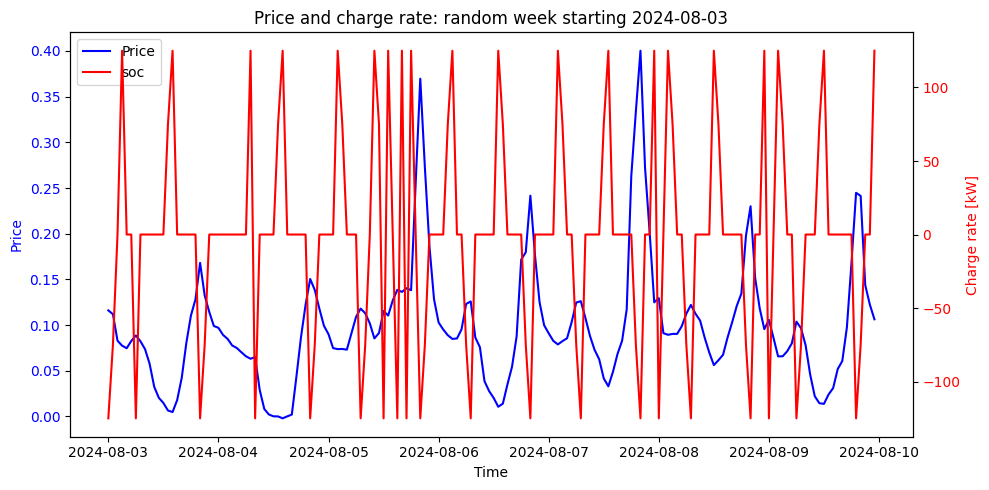

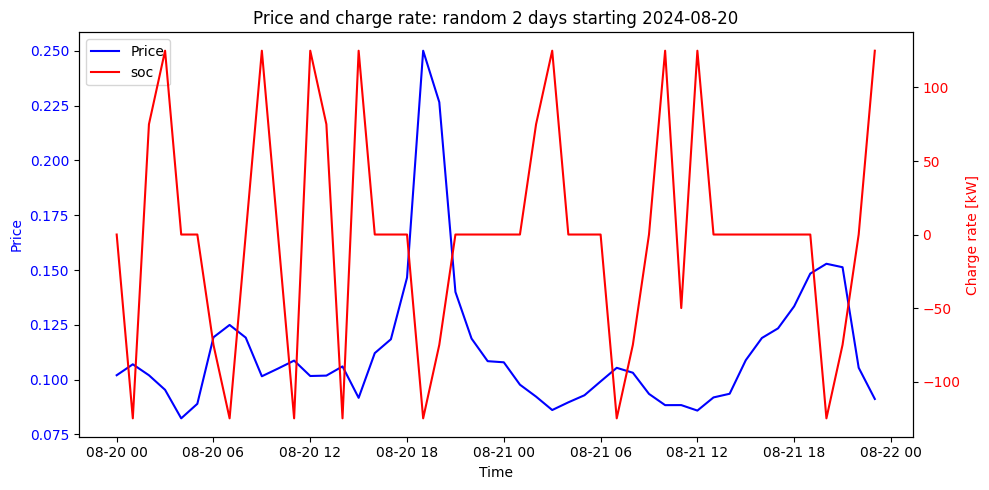

In [146]:
no_charge_hours = [4, 5, 6]
for t in timestamps:
    if t.hour in no_charge_hours:
        objective += charge_rate_var[t] <= 0, f"NoCharge_{t}"

result = solve_lp(objective, charge_rate_var, soc_var, prices)
plot_lp_solution(result)

#### Constraint set 3
- Demand that the battery is at least 50% full at 8:00

Solver Status: Optimal
Total savings: 11525.44€


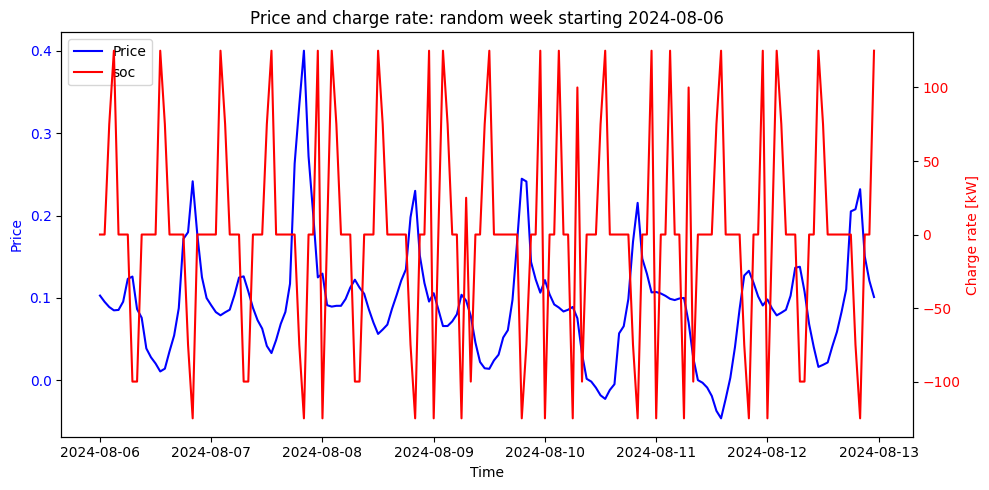

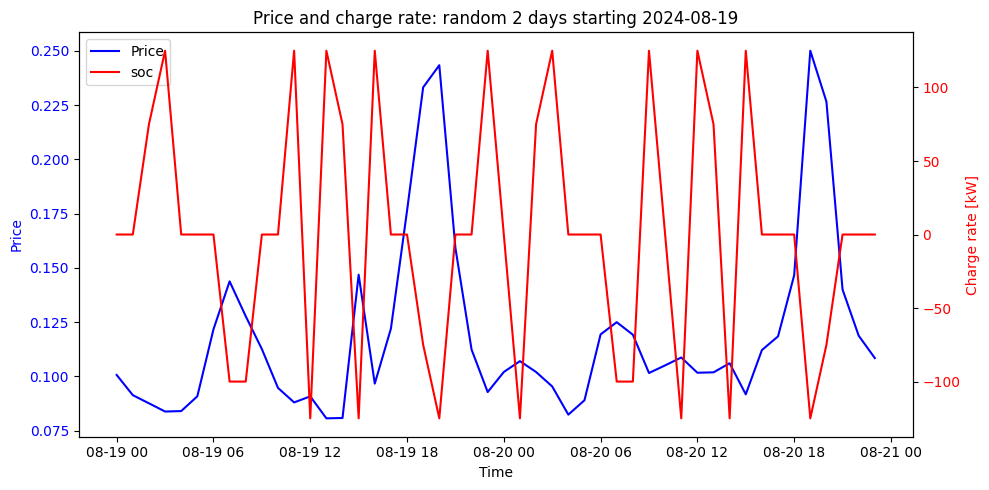

In [147]:
for t in timestamps:
    if t.hour == 8:
        objective += soc_var[t] >= 0.5 * battery.capacity, f"SOC_at_8AM_min{t}"

result = solve_lp(objective, charge_rate_var, soc_var, prices)
plot_lp_solution(result)

#### Constraint set 4
- When solar production/generation is available, assume charging the battery only with solar energy. Charging must therefore not exceed production.

Solver Status: Optimal
Total savings: 6637.55€


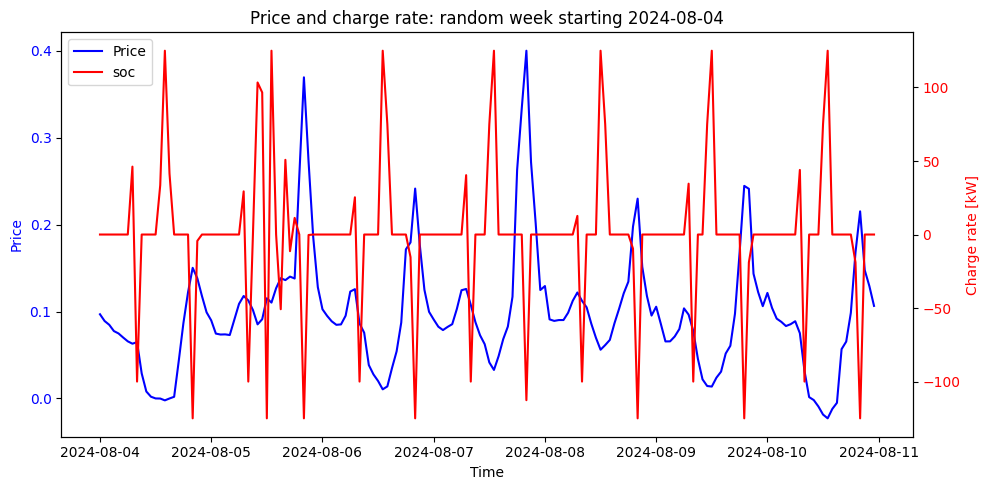

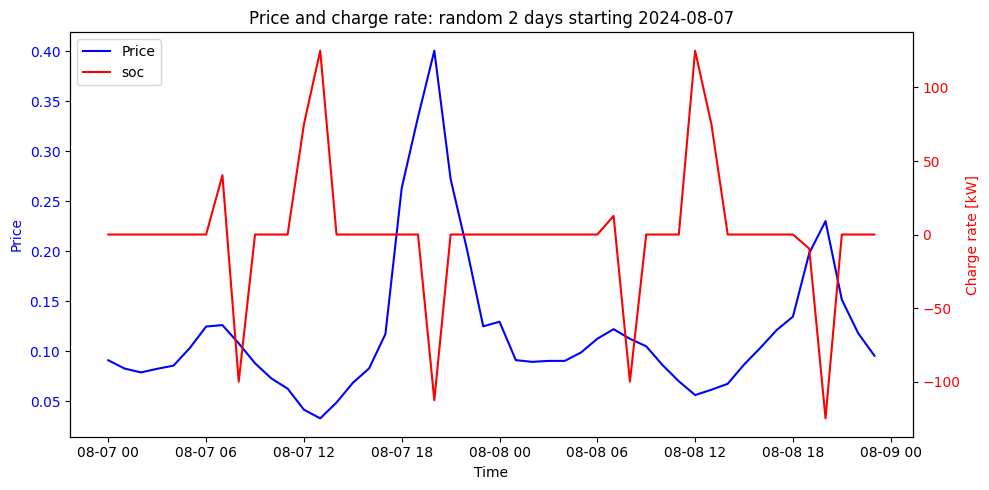

In [148]:
for t in timestamps:
    objective += (
        charge_rate_var[t] <= prices.loc[t, "generation"],
        f"generation_limit_{t}",
    )

result = solve_lp(objective, charge_rate_var, soc_var, prices)
plot_lp_solution(result)

#### Constraint set 5
- Discharging is allowed only if the current price is above the average price

Solver Status: Optimal
Total savings: 4811.06€


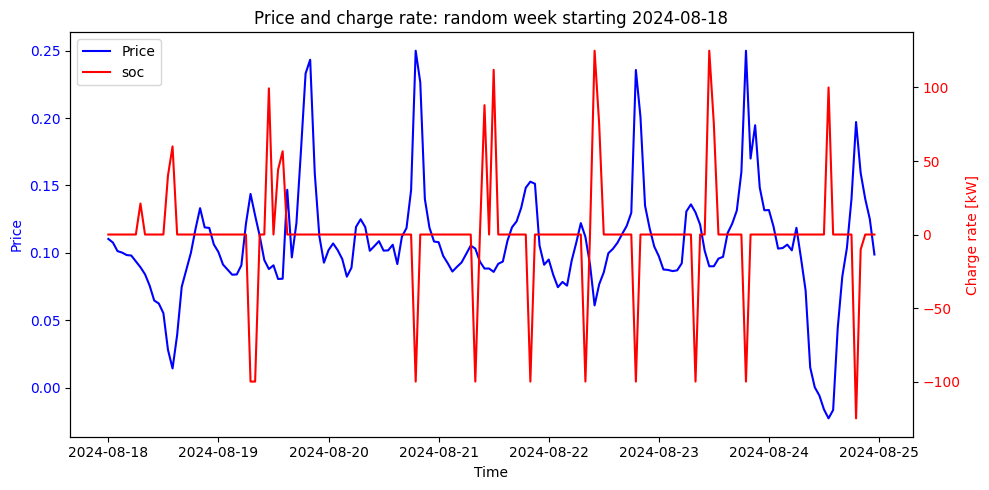

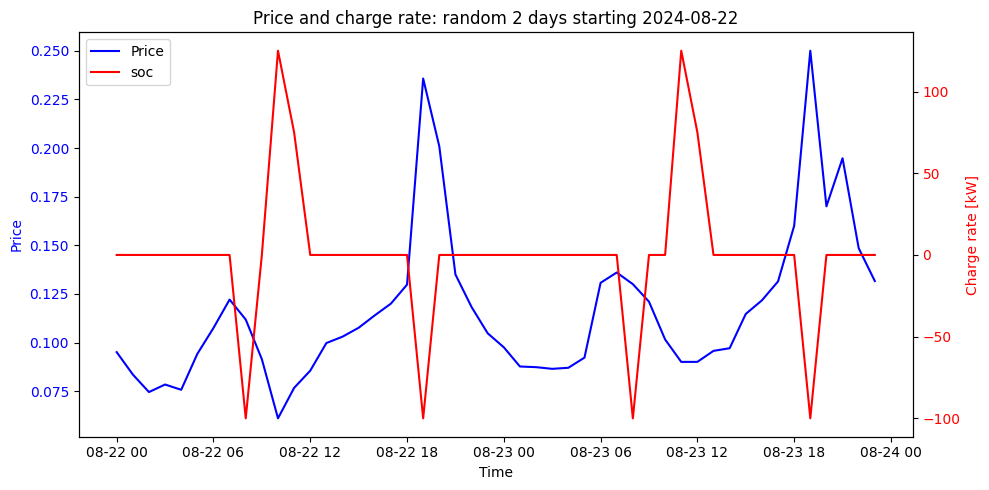

In [ ]:
max_energy_price = prices["energy_price"].max()
avg_energy_price = prices["energy_price"].mean()

for t in timestamps:
    # If is_discharging = 0 → charge_rate ≥ 0  (not discharging)
    # If is_discharging = 1 → charge_rate ≤ 0 (discharging)
    objective += (
        charge_rate_var[t] >= -battery.power * is_discharging_var[t],
        f"discharge_indicator_{t}",
    )
    # If is_discharging = 1 → charge_rate ≤ 0 (discharging)
    objective += (
        charge_rate_var[t] <= (1 - is_discharging_var[t]) * battery.power,
        f"discharge_indicator_b_{t}",
    )

    objective += (
        (
            max_energy_price * is_discharging_var[t]
            - (prices.loc[t, "energy_price"] - avg_energy_price)
            >= 0
        ),
        f"price_upper_{t}",
    )
    objective += (
        (
            -max_energy_price * (1 - is_discharging_var[t])
            - (prices.loc[t, "energy_price"] - avg_energy_price)
            <= 0
        ),
        f"price_lower_{t}",
    )

result = solve_lp(objective, charge_rate_var, soc_var, prices)
plot_lp_solution(result)